# Make Template Vectors
## 11/13/20

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.plotly as py
import plotly
import os
import glob
import math
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import copy
from random import randrange
from sklearn.metrics import jaccard_score
import random

from sklearn.decomposition import PCA #for cluster analysis
from gensim.models import KeyedVectors #for word embeddings
import matplotlib.pyplot as plt #for plotting
import os #for importing
import pickle #for loading transcripts
from scipy.stats import pearsonr 

# from _DRAFT_20200604_functions import * #includes constants and score function
from tqdm import tqdm_notebook #for progress bar

%autosave 5

Autosaving every 5 seconds


# I. Imports
## A. Importing schema texts to form templates

In [2]:
directory = 'template_texts'

filenames = glob.glob(directory + '/*.txt')

dfs = {}
    
for filename in filenames:
    text1 = filename.split("/")[1]
    text2 = int(text1.split(".")[0])
    dfs[text2] = open(filename).read()

## B. Importing wiki vectors

In [3]:
wikipath = 'rolando/wiki-news-300d-1M.vec'
wv_model = KeyedVectors.load_word2vec_format(wikipath)

# II. Functions

In [8]:
wv_dim = 300

# FastText preprocessing, based on bittlingmayer/ft_wiki_preproc.py
# Remove special characters, put spaces between all tokens
SUB = ["s/’/'/g", "s/′/'/g", "s/''/ /g", "s/'/ ' /g", 's/“/"/g', 's/”/"/g', 's/"/ /g', "s/\\./ \\. /g", "s/<br \\/>/ /g", "s/, / , /g", "s/(/ ( /g", "s/)/ ) /g", "s/\\!/ \\! /g", "s/\\?/ \\? /g", "s/\\;/ /g", "s/\\:/ /g", "s/-/ - /g", "s/=/ /g", "s/=/ /g", "s/*/ /g", "s/|/ /g", "s/«/ /g", 
       "s/…/ /g", "s/‘/ /g", "s/í/ /g", "s/ñ/ /g", "s/\x84/ /g", "s/î/ /g", "s/ó/ /g", "s/\x83/ /g", "s/ï/ /g", "s/õ/ /g",
       "s/ò/ /g", "s/,/ /g", "s/ô/ /g", "s/\x92/ /g", "s/é/ /g", "s/\x8e/ /g", "s/â\x80¦/ /g", "s/\x91/ /g", "s/\x93/ /g",
       "s/\x94/ /g", "s/ã®/ /g", "s/ã¨/ /g", "s/ã©/ /g",
       "s/\â\x80\x99/ /g", "s/â\x80\x9c/ /g", "s/â\x80\x9d/ /g", "s/â\x80\x99/ /g", "s/â\x80\x9c/ /g", "s/â\x80\x98/ /g",
       "s/â/ /g"]

def __normalize_text(s):
    for sg in SUB:
        rep = sg.replace('\\','').split('/')
        s = s.replace(rep[1], rep[2])
    s = s.replace('/',' ')
    return s

def __spaces(s):
    return ' '.join(s.split())

def __digits(s):
    return ''.join(filter(lambda c: not c.isdigit(), s))

# def preproc(s):
#     return __punctuation(__spaces(__digits(__normalize_text(s.lower()))))

def preproc(s):
    return (__spaces(__digits(__normalize_text(s.lower()))))

def __punctuation(s):
    return s.translate(str.maketrans('', '', string.punctuation))

def word2vecSent(sentence, model = 'fasttext'):
    wv_dim = 300 #for glove and fasttext
    
    if model == 'glove':
        wvmodel = glove_model
    elif model == 'fasttext':
        wvmodel = wv_model
        
    words = preproc(sentence).split(' ')
    wv = np.zeros((len(words), wv_dim))
    for i in range(len(words)):
        if words[i] in wvmodel.vocab:
            wv[i,:] = wvmodel.word_vec(words[i])
    
    return wv, words

## III. Making the template vectors
### A. Get  a WV for each template

In [21]:
# get word vectors for all templates

wvs = {}
gran_templates = {}

for key in dfs:
    these_wvs, these_words = word2vecSent(dfs[key])
    # Story template
    wvs[key] = np.mean(these_wvs, axis = 0)
    # Matrix with vectors of individual words, and list with words
    gran_templates[key] = {'wvs': these_wvs, 'words': these_words}
    
    
# Concatenating wvs for plotting below
wvs_matrix = np.zeros((8, wv_dim))
order_keys = np.zeros((8,1))
count = 0
for key in wvs:
    wvs_matrix[count, :] = wvs[key]
    order_keys[count] = key
    count += 1

### B. Plotting first 2 PCS

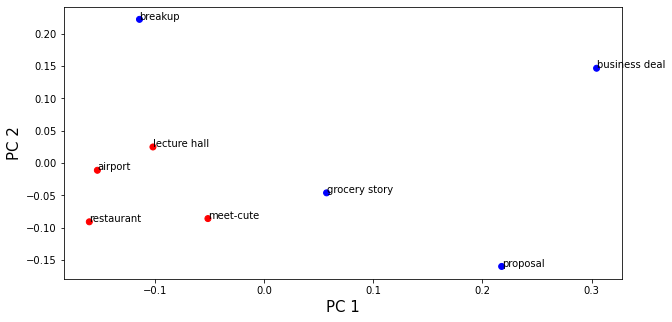

In [25]:
## PCA for first 2 PCs
pca = PCA(n_components=2)
pca.fit(wvs_matrix)
pc12 = pca.transform(wvs_matrix)

# Order keys list
order_keys_list = ['restaurant', 'breakup', 'airport', 'proposal', 'grocery story', 'business deal', 'lecture hall', 'meet-cute']

## plot
plt.figure(figsize=(10,5))

y = ['r' if sc%10 == 0 else 'b' for sc in order_keys] ## for coloring points by schema

plt.scatter(pc12[:,0], pc12[:,1],c=y)

for i in range(8):
    plt.text(pc12[i, 0], pc12[i, 1], s= order_keys_list[i] )
    
plt.xlabel("PC 1", fontsize=15); plt.ylabel("PC 2",fontsize=15);




## IV. Exporting vector templates

In [26]:
pickle.dump( wvs, open( 'template_vectors', "wb" ) )

# V. Exporting gran_templates

In [27]:
pickle.dump( gran_templates, open( 'gran_templates', "wb" ) )